In [1]:
using BenchmarkTools, Compat, DataFrames, Distributions, ForwardDiff, Plots

In [2]:
# Stochastic gradient descent, logit.

df = readtable("../data/parsed_model_australia.txt", separator = ' ', header = false)

a, b = size(df)

const n_individuals = a
const n_alternatives = 4
const n_parameters = b
const n_simulations = 1000
const simulated_b = 5

srand(123456)

rand_contdist(Dist::Distribution) = quantile(Dist, rand())

rand_contdist (generic function with 1 method)

In [3]:
mixed_logit = zeros(n_individuals, n_simulations)

function simulate()
    for i = 1:n_individuals, j = 1:n_simulations
        mixed_logit[i, j] = rand()
    end
end

simulate()

In [4]:
function individual(θ::Vector, i::Int64)
    m, n = size(df)
    choice = df[i, 1][1]
    alternatives = collect(1:n_alternatives)
    splice!(alternatives, choice)
    
    function utility(β::Vector, k::Int64)
        temp = Float64[]
        k += 1
        while k <= n_parameters
            push!(temp, df[i, k])
            k += n_alternatives
        end
        return dot(temp, β)
    end
    
    function construct(γ::Vector, θ::Vector)
        return θ[1]+θ[2]*γ[1]
    end
    
    function probability(θ::Vector)
        logit = 0.0
        t = 0.0
        for k = 1:n_simulations
            β = []
            for j = 1:simulated_b-1
                push!(β, θ[j])
            end
            γ = [mixed_logit[i, k]]
            push!(β, construct(γ, θ[simulated_b:simulated_b+1]))
            for j = simulated_b+2:length(θ)
                push!(β, θ[j])
            end 
            c = utility(β, choice)
            for alternative in alternatives
                t += exp(utility(β, alternative)-c)
            end
            logit += 1/(1+t)
        end
        return logit/n_simulations
    end
    
    return probability
end

individual (generic function with 1 method)

In [5]:
function f(β::Vector)
    model = 0.0
    i = 1
    while i <= n_individuals
        logit = individual(β, i)
        model += log(logit(β))
        i += 1
    end
    return -model/n_individuals
end

f (generic function with 1 method)

In [6]:
function g(x::Vector, i::Int64, j::Int64)
    t = zeros(length(x))
    for k = i:j
        logit = individual(x, k)
        t += (1/logit(x))*ForwardDiff.gradient(logit, x)
    end
    return -t/j
end

function g!(x::Vector, i::Int64, j::Int64, storage::Vector)
    s = g(x, i, j)
    storage[1:length(s)] = s[1:length(s)]
end

g! (generic function with 1 method)

In [7]:
function H(x::Vector)
    return ForwardDiff.hessian(f, x)
end

function H!(x::Vector, storage::Matrix)
    s = H(x)
    n, m = size(s)
    storage[1:n, 1:m] = s[1:length(s)]
end

H! (generic function with 1 method)

In [8]:
function shuffle!(df::DataFrame)
    for i = size(df, 1):-1:2
        j = rand(1:i)
        df[i, :], df[j, :] = df[j, :], df[i, :]
    end
end

shuffle! (generic function with 1 method)


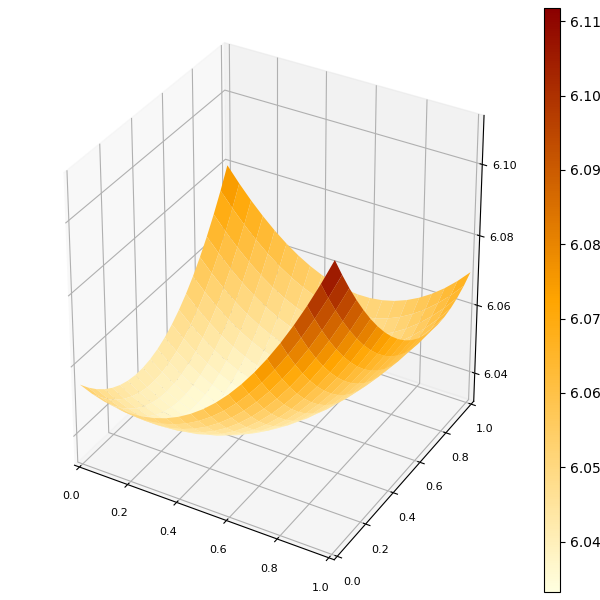

In [9]:
default(size = (600, 600), fc = :heat)
β1, β2 = 0:0.05:1.0, 0:0.05:1.0
z = Surface((β1, β2) -> f([β1, β2, 0, 0, 0, 0, 0]), β1, β2)
surface(β1, β2, z, linealpha = 0.3)

In [10]:
function predict(β::Vector, i::Int64)
    logit = individual(β, i)
    return logit(β)
end

predict (generic function with 1 method)

In [11]:
function sgd(f::Function, g!::Function, ω0::Vector, η::Float64,
        batch::Int64 = 1, tol::Float64 = 1e-12, record::Bool = true)
    k = 1
    ω = ω0
    n = length(ω)
    dfx = ones(n)
    nmax = 25 # epochs
    change = 1.0
    if record
        fω = f(ω)
        iterates = [ fω ω' ]
    end
    # tol trop sévère, il va s'arrêter trop tôt.
    # while norm(dfx) > tol && k < nmax
    while k < nmax
        shuffle!(df)
        x = ω
        for i = 1:batch:n_individuals
            ω -= (η*g!(x, i, batch, dfx))
        end
        if record
            fω = f(ω)
            iterates = [ iterates; fω ω' ]
        end
        change = abs(f(ω)-f(x))
        k += 1
    end
    if record
        return ω, k, iterates
    else
        return ω, k
    end
end

sgd (generic function with 4 methods)

In [12]:
sol, epochs, iter = sgd(f, g!, [6.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0], 0.001)

sol, epochs

([5.99995, 4.00139, 3.00224, 0.118156, -0.121674, 0.00515918, 0.0472063], 25)


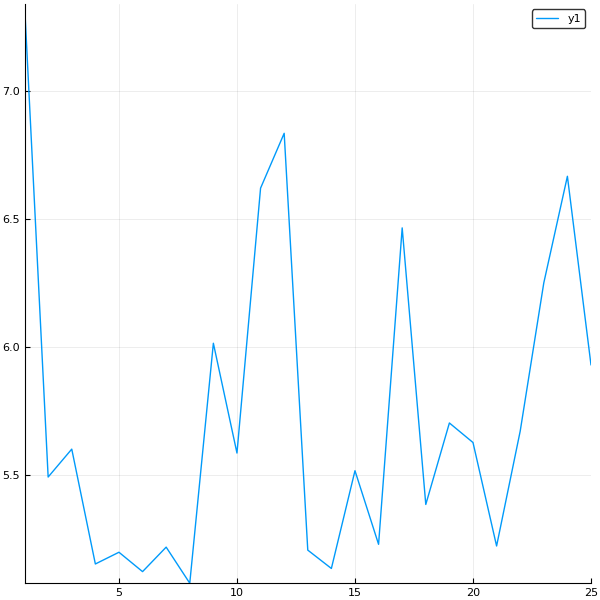

In [13]:
k = [x = i for i = 1:length(iter[:, 1])]

Plots.plot(k, iter[:, 1])